<a href="https://colab.research.google.com/github/kingloogie/QTM-347-Machine-Learning-Final-Project/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Link to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import data

In [ ]:
import os
import shutil

# Define source folders from Google Drive
real_src = '/content/drive/MyDrive/QTM 347 Final Project/Cleaned_Image_Data_Folder/real'
fake_src = '/content/drive/MyDrive/QTM 347 Final Project/Cleaned_Image_Data_Folder/fake'

# Define target folders inside Colab for Keras
real_dst = '/content/dataset/train/real'
fake_dst = '/content/dataset/train/fake'

# Create destination folders
os.makedirs(real_dst, exist_ok=True)
os.makedirs(fake_dst, exist_ok=True)

# Copy real images
for filename in os.listdir(real_src):
    src_file = os.path.join(real_src, filename)
    dst_file = os.path.join(real_dst, filename)
    if os.path.isfile(src_file):
        shutil.copy(src_file, dst_file)

# Copy fake images
for filename in os.listdir(fake_src):
    src_file = os.path.join(fake_src, filename)
    dst_file = os.path.join(fake_dst, filename)
    if os.path.isfile(src_file):
        shutil.copy(src_file, dst_file)


In [ ]:
# Data cleaning and data validation

📁 Validating dataset structure...

✅ Found 917 images in 'Real' folder.

🔍 Showing 3 random 'Real' images:


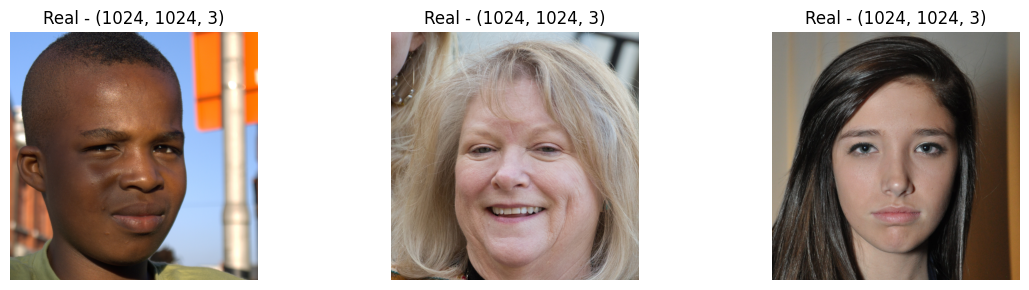

✅ Found 910 images in 'Fake' folder.

🔍 Showing 3 random 'Fake' images:


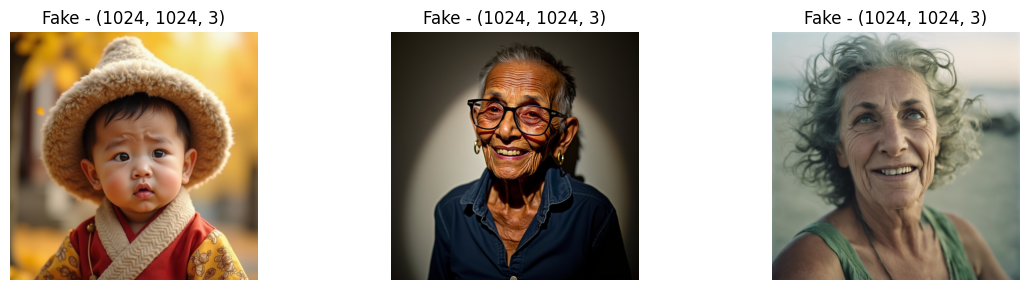

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random

# Paths to your dataset folders
real_path = '/content/dataset/train/real'
fake_path = '/content/dataset/train/fake'

# Function to validate folder structure
def validate_dataset_structure(real_path, fake_path):
    print("📁 Validating dataset structure...\n")

    for label, path in zip(['Real', 'Fake'], [real_path, fake_path]):
        if not os.path.exists(path):
            print(f"❌ ERROR: Missing folder: {path}")
            continue

        files = os.listdir(path)
        image_files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        print(f"✅ Found {len(image_files)} images in '{label}' folder.")

        if len(image_files) == 0:
            print(f"⚠️ WARNING: No valid image files found in {label} folder.")

        # Display random sample images
        print(f"\n🔍 Showing 3 random '{label}' images:")
        sample = random.sample(image_files, min(3, len(image_files)))
        plt.figure(figsize=(12, 3))
        for i, file in enumerate(sample):
            try:
                img_path = os.path.join(path, file)
                img = Image.open(img_path)
                img_array = np.array(img)

                plt.subplot(1, 3, i+1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{label} - {img_array.shape}")
            except Exception as e:
                print(f"⚠️ Could not open image {file}: {e}")
        plt.tight_layout()
        plt.show()

# Run the check
validate_dataset_structure(real_path, fake_path)


In [ ]:
# split dataset into 0.2/0.8
import os
import shutil
from sklearn.model_selection import train_test_split

def split_dataset(source_dir, target_base, test_size=0.2):
    for label in ['real', 'fake']:
        src = os.path.join(source_dir, label)
        images = [f for f in os.listdir(src) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        train_imgs, val_imgs = train_test_split(images, test_size=test_size, random_state=42)

        for split, split_imgs in zip(['train', 'validation'], [train_imgs, val_imgs]):
            dst = os.path.join(target_base, split, label)
            os.makedirs(dst, exist_ok=True)
            for img in split_imgs:
                src_file = os.path.join(src, img)
                dst_file = os.path.join(dst, img)
                if os.path.abspath(src_file) != os.path.abspath(dst_file):
                    shutil.copy(src_file, dst_file)

# 🔁 Do this once (new folder location)
split_dataset('/content/dataset/train', '/content/split_dataset')



In [ ]:
## Set up ImageDataGenerators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/split_dataset/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/split_dataset/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)


Found 1461 images belonging to 2 classes.
Found 366 images belonging to 2 classes.


Above is the data cleaning

In [ ]:
##### Build the Resnet.50 Model

In [ ]:
# Build the Resnet.50 Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])


Epoch 1/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.4966 - loss: 0.8637 - val_accuracy: 0.5027 - val_loss: 0.6950
Epoch 2/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5223 - loss: 0.7139 - val_accuracy: 0.5027 - val_loss: 0.7117
Epoch 3/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.5599 - loss: 0.6994 - val_accuracy: 0.5109 - val_loss: 0.6749
Epoch 4/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5852 - loss: 0.6754 - val_accuracy: 0.5137 - val_loss: 0.6724
Epoch 5/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5680 - loss: 0.6776 - val_accuracy: 0.5164 - val_loss: 0.6707
Epoch 6/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.5852 - loss: 0.6655 - val_accuracy: 0.5765 - val_loss: 0.6410
Epoch 7/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.6386 - loss: 0.6409 - val_accuracy: 0.6421 - val_loss: 0.6161


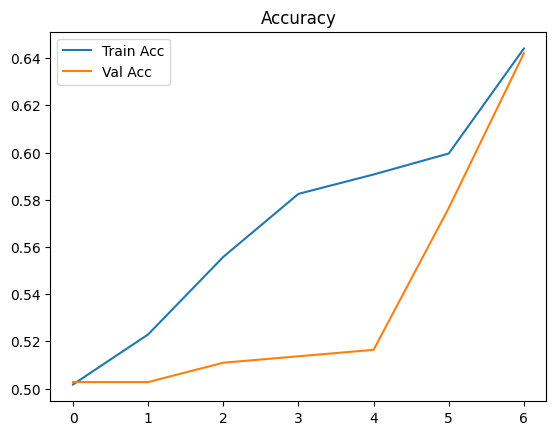

In [ ]:
# Train the Model
EPOCHS = 7
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

# Plot training curves
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Fine tuning, unfreeze all

In [ ]:
# Step 1: Unfreeze the base ResNet50 model
base_model.trainable = True

# Step 2: Recompile the model with a smaller learning rate
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(1e-5),  # smaller learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 3: Continue training for more epochs
fine_tune_epochs = 7

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs
)


Epoch 1/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.6072 - loss: 0.8980 - val_accuracy: 0.5437 - val_loss: 0.6694
Epoch 2/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9238 - loss: 0.2058 - val_accuracy: 0.6093 - val_loss: 0.6736
Epoch 3/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9824 - loss: 0.0866 - val_accuracy: 0.5027 - val_loss: 0.6886
Epoch 4/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9826 - loss: 0.0499 - val_accuracy: 0.4973 - val_loss: 0.7008
Epoch 5/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9911 - loss: 0.0413 - val_accuracy: 0.5027 - val_loss: 0.6899
Epoch 6/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9878 - loss: 0.0405 - val_accuracy: 0.5301 - val_loss: 0.6844
Epoch 7/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9961 - loss: 0.0204 - val_accuracy: 0.5710 - val_loss: 0.6853


Above fine tuning faces overfitting problem.

In [ ]:
## This code below adds regularization to prevent overfitting problem

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Step 1: Unfreeze top 30 layers of ResNet50
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Step 2: Rebuild the model with regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)  # increased dropout to reduce overfitting
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)  # L2 regularization
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Step 3: Recompile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 4: Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 5: Train the model
fine_tune_epochs = 7
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=fine_tune_epochs,
    callbacks=[early_stop]
)

Epoch 1/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6327 - loss: 0.6740 - val_accuracy: 0.5191 - val_loss: 0.6787
Epoch 2/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8077 - loss: 0.4923 - val_accuracy: 0.7650 - val_loss: 0.5373
Epoch 3/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.8843 - loss: 0.3593 - val_accuracy: 0.9044 - val_loss: 0.3495
Epoch 4/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9337 - loss: 0.2520 - val_accuracy: 0.9372 - val_loss: 0.2317
Epoch 5/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9418 - loss: 0.2155 - val_accuracy: 0.9617 - val_loss: 0.1611
Epoch 6/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9629 - loss: 0.1563 - val_accuracy: 0.9672 - val_loss: 0.1330
Epoch 7/7
46/46 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9583 - loss: 0.1536 - val_accuracy: 0.9754 - val_loss: 0.1086


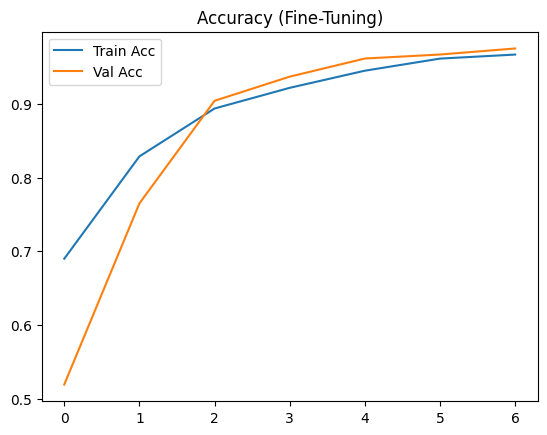

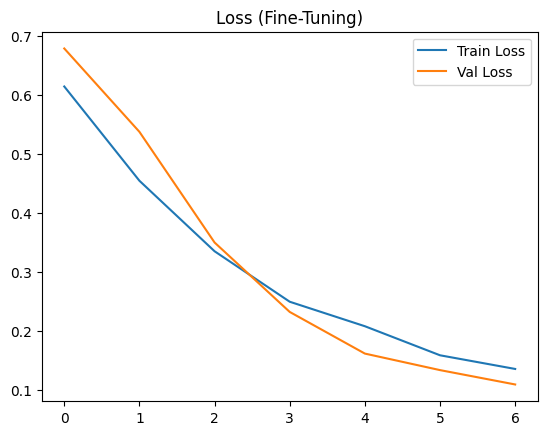

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history_finetune.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy (Fine-Tuning)')
plt.legend()
plt.show()

plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title('Loss (Fine-Tuning)')
plt.legend()
plt.show()

